# Equations with first order term

In [1]:
!test -d /var/colab && pip install poetry
!test -d /var/colab && pip install git+https://github.com/gbonnet1/notebooks.git

In [2]:
import agd.LinearParallel as lp
import matplotlib.pyplot as plt
import numpy as np
from agd import Domain, Selling
from agd.AutomaticDifferentiation import Dense2, Sparse
from agd.AutomaticDifferentiation.misc import tocsr
from agd.AutomaticDifferentiation.Optimization import newton_root
from scipy.sparse import diags
from scipy.sparse.linalg import eigs, spsolve

In [3]:
def domain(d):
    return Domain.Union(
        Domain.Ball(center=d * [0], radius=1 / np.sqrt(d)),
        Domain.Box(sides=d * [(0, 1 / np.sqrt(d))]),
    )

In [4]:
def grid(d, h):
    return np.stack(
        np.meshgrid(
            *(d * [np.arange(-h * np.floor(1 / (np.sqrt(d) * h)), 1 / np.sqrt(d), h)]),
            indexing="ij",
        )
    )

In [5]:
def omega0(x):
    d = x.shape[0]

    if d == 2:
        return np.stack([np.cos(2 * np.pi * x[1]), np.sin(2 * np.pi * x[1])])
    elif d == 3:
        return np.stack(
            [
                np.cos(2 * np.pi * x[1]),
                np.sin(2 * np.pi * x[1]) * np.cos(2 * np.pi * x[2]),
                np.sin(2 * np.pi * x[1]) * np.sin(2 * np.pi * x[2]),
            ]
        )
    else:
        raise ValueError(f"Invalid dimension: {d}")


def omega(x):
    return (2 - np.cos(2 * np.pi * x[0])) / 3 * omega0(x)


def D(x):
    return (
        mu
        * (2 + np.cos(2 * np.pi * x[0]))
        / 3
        * (
            nu * lp.identity(x.shape[1:])
            + (1 - nu) * lp.outer(omega0(x / 2), omega0(x / 2))
        )
    )

In [6]:
def u1(x):
    return 1 / 4 * lp.dot_VV(x, x) ** 2


def u2(x):
    return 2 / 3 * np.maximum(0, np.sqrt(lp.dot_VV(x, x)) - 0.3) ** 2.5


def u3(x):
    return np.where(lp.dot_VV(x, x) < 1, 1 / 2 * np.sqrt(1 - lp.dot_VV(x, x)), 0)

In [7]:
def EqLinear(u_func, x):
    x_ad = Dense2.identity(constant=x, shape_free=x.shape[:1])
    u_ad = u_func(x_ad)
    du = np.moveaxis(u_ad.coef1, -1, 0)
    d2u = np.moveaxis(u_ad.coef2, [-2, -1], [0, 1])
    return -lp.dot_VV(omega(x), du) - lp.trace(lp.dot_AA(D(x), d2u))


def SchemeLinear(u, x, f, bc):
    coef, offsets = Selling.Decomposition(D(x))

    # coef_min = np.min(coef)
    # offsets_norm2 = lp.dot_VV(offsets, offsets)
    # offsets_max2 = np.max(np.where(coef < 1e-13, 0, offsets_norm2))
    # print(f"h: {bc.gridscale}, c: {coef_min}, e2: {offsets_max2}")

    du = bc.DiffCentered(u, offsets)
    d2u = bc.Diff2(u, offsets)
    return np.where(
        bc.interior,
        -lp.dot_VAV(omega(x), lp.inverse(D(x)), np.sum(coef * du * offsets, axis=1))
        - lp.dot_VV(coef, d2u)
        - f,
        u - bc.grid_values,
    )


def SolveLinear(x, f, bc):
    u = Sparse.identity(constant=np.zeros(x.shape[1:]))
    residue = SchemeLinear(u, x, f, bc)

    triplets, rhs = residue.solve(raw=True)
    mat = tocsr(triplets)

    if False:
        (val_max,), _ = eigs(mat, 1, which="LM")
        (val_min,), _ = eigs(mat, 1, which="SM")
        print(val_max / val_min)

    dde = (diags(mat.diagonal()) - mat).min() > -1e-8

    precond = diags(1 / mat.diagonal())
    matprecond = precond @ mat
    rhsprecond = precond @ rhs

    if False:
        (val_max,), _ = eigs(matprecond, 1, which="LM")
        (val_min,), _ = eigs(matprecond, 1, which="SM")
        print(val_max / val_min)

    return spsolve(matprecond, rhsprecond).reshape(x.shape[1:]), dde

In [8]:
def EqNonlinear(u_func, x):
    x_ad = Dense2.identity(constant=x, shape_free=x.shape[:1])
    u_ad = u_func(x_ad)
    du = np.moveaxis(u_ad.coef1, -1, 0)
    d2u = np.moveaxis(u_ad.coef2, [-2, -1], [0, 1])
    return -1 / 2 * lp.dot_VV(omega(x), du) ** 2 - lp.trace(lp.dot_AA(D(x), d2u))


def SchemeNonlinear(u, x, f, bc):
    coef, offsets = Selling.Decomposition(D(x))
    du = bc.DiffCentered(u, offsets)
    d2u = bc.Diff2(u, offsets)
    p = lp.dot_AV(lp.inverse(D(x)), np.sum(coef * du * offsets, axis=1))
    return np.where(
        bc.interior,
        -1 / 2 * lp.dot_VV(omega(x), p) ** 2 - lp.dot_VV(coef, d2u) - f,
        u - bc.grid_values,
    )


def SolveNonlinear(x, f, bc):
    dde = True

    def Solver(residue):
        nonlocal dde

        triplets, rhs = residue.solve(raw=True)
        mat = tocsr(triplets)

        # if (diags(mat.diagonal()) - mat).min() <= -1e-8:
        #     dde = False

        dde = (diags(mat.diagonal()) - mat).min() > -1e-8

        precond = diags(1 / mat.diagonal())
        matprecond = precond @ mat
        rhsprecond = precond @ rhs

        return spsolve(matprecond, rhsprecond).reshape(x.shape[1:])

    result = newton_root(
        SchemeNonlinear, 0.0001 * lp.dot_VV(x, x), params=(x, f, bc), solver=Solver
    )

    return result, dde

/Users/guillaume/.pyenv/versions/3.6.10/envs/notebooks/lib/python3.6/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


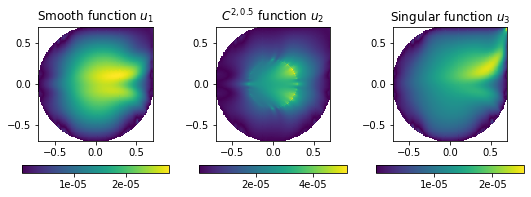

In [9]:
d = 2
mu = 1
nu = 1 / 10
h = 0.01

plt.figure(figsize=(9, 3))

for i, (u_func, title) in enumerate(
    [
        (u1, "Smooth function $u_1$"),
        (u2, "$C^{2, 0.5}$ function $u_2$"),
        (u3, "Singular function $u_3$"),
    ]
):
    x = grid(d, h)
    bc = Domain.Dirichlet(domain(d), u_func, x)

    u = u_func(x)
    f = EqLinear(u_func, x)

    u_approx, _ = SolveLinear(x, f, bc)

    plt.subplot(131 + i, aspect="equal")
    plt.title(title)
    im = plt.pcolormesh(*x, np.where(bc.interior, np.abs(u - u_approx), np.nan))
    plt.colorbar(im, orientation="horizontal", format="%.0e")

plt.savefig("linear-error-2d.png")
plt.show()

0.1 False
0.08705505632961241 False
0.07578582832551992 False
0.0659753955386447 False
0.05743491774985175 False
0.05 True
0.043527528164806206 True
0.03789291416275995 True
0.03298769776932235 True
0.028717458874925876 True
0.025 True
0.021763764082403103 True
0.018946457081379972 True
0.016493848884661176 True
0.014358729437462935 True
0.0125 True
0.1 False
0.08705505632961241 False
0.07578582832551992 False
0.0659753955386447 False
0.05743491774985175 False
0.05 True


/Users/guillaume/.pyenv/versions/3.6.10/envs/notebooks/lib/python3.6/site-packages/agd/AutomaticDifferentiation/Base.py:42: RuntimeWarning: divide by zero encountered in power
  def pow(x,n):	return (x**n,n*x**(n-1),(n*(n-1))*x**(n-2))
/Users/guillaume/.pyenv/versions/3.6.10/envs/notebooks/lib/python3.6/site-packages/agd/AutomaticDifferentiation/Dense2.py:99: RuntimeWarning: invalid value encountered in multiply
  return self.new(a,_add_dim(b)*self.coef1,_add_dim2(b)*self.coef2+_add_dim2(c)*mixed)


0.043527528164806206 True
0.03789291416275995 True
0.03298769776932235 True
0.028717458874925876 True
0.025 True
0.021763764082403103 True
0.018946457081379972 True
0.016493848884661176 True
0.014358729437462935 True
0.0125 True
0.1 False
0.08705505632961241 False
0.07578582832551992 False
0.0659753955386447 False
0.05743491774985175 False
0.05 True
0.043527528164806206 True
0.03789291416275995 True
0.03298769776932235 True
0.028717458874925876 True
0.025 True
0.021763764082403103 True
0.018946457081379972 True
0.016493848884661176 True
0.014358729437462935 True
0.0125 True


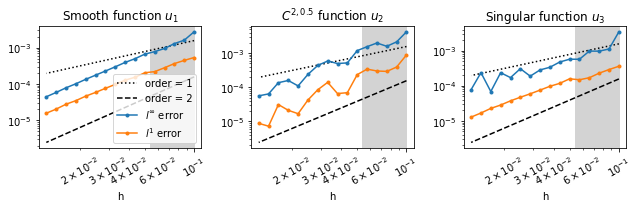

In [10]:
d = 2
mu = 1
nu = 1 / 10
h = 0.1 / 2 ** np.arange(0, 3.2, 0.2)

plt.figure(figsize=(9, 3))

for i, (u_func, title) in enumerate(
    [
        (u1, "Smooth function $u_1$"),
        (u2, "$C^{2, 0.5}$ function $u_2$"),
        (u3, "Singular function $u_3$"),
    ]
):
    err_l1 = np.zeros(h.shape)
    err_linf = np.zeros(h.shape)

    plt.subplot(131 + i)
    plt.title(title)
    plt.xlabel("h")

    for j in range(len(h)):
        x = grid(d, h[j])
        bc = Domain.Dirichlet(domain(d), u_func, x)

        u = u_func(x)
        f = EqLinear(u_func, x)

        u_approx, dde = SolveLinear(x, f, bc)

        print(h[j], dde)

        if not dde:
            plt.axvspan(
                np.exp((np.log(h[min(len(h) - 1, j + 1)]) + np.log(h[j])) / 2),
                np.exp((np.log(h[j]) + np.log(h[max(0, j - 1)])) / 2),
                color="lightgray",
            )

        err_l1[j] = np.mean(np.abs(np.where(bc.interior, u - u_approx, 0)))
        err_linf[j] = np.max(np.abs(np.where(bc.interior, u - u_approx, 0)))

    plt.loglog(h, h / 64, "k:", label="order = 1")
    plt.loglog(h, h ** 2 / 64, "k--", label="order = 2")
    plt.loglog(h, err_linf, ".-", label="$l^\infty$ error")
    plt.loglog(h, err_l1, ".-", label="$l^1$ error")

    if i == 0:
        plt.legend()
    plt.xticks(rotation=30)
    for text in plt.gca().get_xminorticklabels():
        text.set_rotation(30)

plt.tight_layout()
plt.savefig("linear-convergence-2d.png")
plt.show()

Iteration: 1  Residue norm: 119.97135370690056
Iteration: 2  Residue norm: 13.472646118162643
Iteration: 3  Residue norm: 2.7848772741612047
Iteration: 4  Residue norm: 0.34514489865087933
Iteration: 5  Residue norm: 0.009370932496020945
Iteration: 6  Residue norm: 7.723381985791367e-06
Iteration: 7  Residue norm: 5.2647330939237236e-12
Target residue reached. Terminating.
0.1 False
Iteration: 1  Residue norm: 44.794343006220274
Iteration: 2  Residue norm: 5.465776677087481
Iteration: 3  Residue norm: 0.850839104608041
Iteration: 4  Residue norm: 0.07433025990688599
Iteration: 5  Residue norm: 0.0008326422643969711
Iteration: 6  Residue norm: 1.0931022551008418e-07
Iteration: 7  Residue norm: 8.049116928532385e-15
Target residue reached. Terminating.
0.08705505632961241 False
Iteration: 1  Residue norm: 5.422421385823128
Iteration: 2  Residue norm: 0.9181803780054023
Iteration: 3  Residue norm: 0.06044152654220192
Iteration: 4  Residue norm: 0.00034551503052882016
Iteration: 5  Residue

/Users/guillaume/.pyenv/versions/3.6.10/envs/notebooks/lib/python3.6/site-packages/agd/AutomaticDifferentiation/Base.py:42: RuntimeWarning: divide by zero encountered in power
  def pow(x,n):	return (x**n,n*x**(n-1),(n*(n-1))*x**(n-2))
/Users/guillaume/.pyenv/versions/3.6.10/envs/notebooks/lib/python3.6/site-packages/agd/AutomaticDifferentiation/Dense2.py:99: RuntimeWarning: invalid value encountered in multiply
  return self.new(a,_add_dim(b)*self.coef1,_add_dim2(b)*self.coef2+_add_dim2(c)*mixed)


Iteration: 2  Residue norm: 1.1748242206090864
Iteration: 3  Residue norm: 0.08853865225675317
Iteration: 4  Residue norm: 0.0006934225759386847
Iteration: 5  Residue norm: 4.3863837728697064e-08
Iteration: 6  Residue norm: 2.3314683517128287e-15
Target residue reached. Terminating.
0.07578582832551992 False
Iteration: 1  Residue norm: 35.34759760317705
Iteration: 2  Residue norm: 8.517192977721997
Iteration: 3  Residue norm: 1.8417746085656255
Iteration: 4  Residue norm: 0.2664033498263171
Iteration: 5  Residue norm: 0.011012607960102339
Iteration: 6  Residue norm: 2.2363450415285868e-05
Iteration: 7  Residue norm: 9.297648762007782e-11
Target residue reached. Terminating.
0.0659753955386447 False
Iteration: 1  Residue norm: 23.765870833189222
Iteration: 2  Residue norm: 5.424477217659183
Iteration: 3  Residue norm: 0.9417459588401076
Iteration: 4  Residue norm: 0.06631202157133165
Iteration: 5  Residue norm: 0.0004447146951850889
Iteration: 6  Residue norm: 2.0532216066238007e-08
Ite

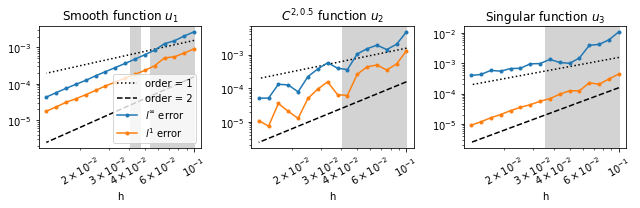

In [11]:
d = 2
mu = 1 / 4
nu = 1 / 10
h = 0.1 / 2 ** np.arange(0, 3.2, 0.2)

plt.figure(figsize=(9, 3))

for i, (u_func, title) in enumerate(
    [
        (u1, "Smooth function $u_1$"),
        (u2, "$C^{2, 0.5}$ function $u_2$"),
        (u3, "Singular function $u_3$"),
    ]
):
    err_l1 = np.zeros(h.shape)
    err_linf = np.zeros(h.shape)

    plt.subplot(131 + i)
    plt.title(title)
    plt.xlabel("h")

    for j in range(len(h)):
        x = grid(d, h[j])
        bc = Domain.Dirichlet(domain(d), u_func, x)

        u = u_func(x)
        f = EqNonlinear(u_func, x)

        u_approx, dde = SolveNonlinear(x, f, bc)

        print(h[j], dde)

        if not dde:
            plt.axvspan(
                np.exp((np.log(h[min(len(h) - 1, j + 1)]) + np.log(h[j])) / 2),
                np.exp((np.log(h[j]) + np.log(h[max(0, j - 1)])) / 2),
                color="lightgray",
            )

        err_l1[j] = np.mean(np.abs(np.where(bc.interior, u - u_approx, 0)))
        err_linf[j] = np.max(np.abs(np.where(bc.interior, u - u_approx, 0)))

    plt.loglog(h, h / 64, "k:", label="order = 1")
    plt.loglog(h, h ** 2 / 64, "k--", label="order = 2")
    plt.loglog(h, err_linf, ".-", label="$l^\infty$ error")
    plt.loglog(h, err_l1, ".-", label="$l^1$ error")

    if i == 0:
        plt.legend()
    plt.xticks(rotation=30)
    for text in plt.gca().get_xminorticklabels():
        text.set_rotation(30)

plt.tight_layout()
plt.savefig("nonlinear-convergence-2d.png")
plt.show()

0.21 False
0.18281561829218604 True
0.1591502394835918 True
0.13854833063115388 False
0.12061332727468867 True
0.105 True
0.09140780914609302 False
0.07957511974179589 True
0.06927416531557694 True
0.060306663637344333 True
0.0525 True
0.21 False
0.18281561829218604 True
0.1591502394835918 True
0.13854833063115388 False


/Users/guillaume/.pyenv/versions/3.6.10/envs/notebooks/lib/python3.6/site-packages/agd/AutomaticDifferentiation/Base.py:42: RuntimeWarning: divide by zero encountered in power
  def pow(x,n):	return (x**n,n*x**(n-1),(n*(n-1))*x**(n-2))
/Users/guillaume/.pyenv/versions/3.6.10/envs/notebooks/lib/python3.6/site-packages/agd/AutomaticDifferentiation/Dense2.py:99: RuntimeWarning: invalid value encountered in multiply
  return self.new(a,_add_dim(b)*self.coef1,_add_dim2(b)*self.coef2+_add_dim2(c)*mixed)


0.12061332727468867 True
0.105 True
0.09140780914609302 False
0.07957511974179589 True
0.06927416531557694 True
0.060306663637344333 True
0.0525 True
0.21 False
0.18281561829218604 True
0.1591502394835918 True
0.13854833063115388 False


/Users/guillaume/.pyenv/versions/3.6.10/envs/notebooks/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in sqrt
  # Remove the CWD from sys.path while we load stuff.


0.12061332727468867 True
0.105 True
0.09140780914609302 False
0.07957511974179589 True
0.06927416531557694 True
0.060306663637344333 True
0.0525 True


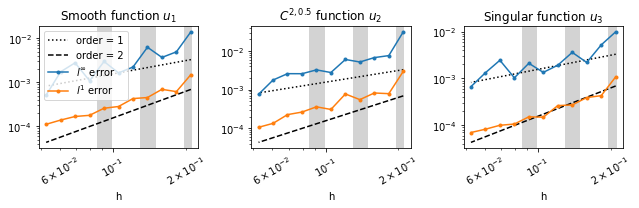

In [12]:
d = 3
mu = 3
nu = 1 / 10
h = 0.21 / 2 ** np.arange(0, 2.2, 0.2)

plt.figure(figsize=(9, 3))

for i, (u_func, title) in enumerate(
    [
        (u1, "Smooth function $u_1$"),
        (u2, "$C^{2, 0.5}$ function $u_2$"),
        (u3, "Singular function $u_3$"),
    ]
):
    err_l1 = np.zeros(h.shape)
    err_linf = np.zeros(h.shape)

    plt.subplot(131 + i)
    plt.title(title)
    plt.xlabel("h")

    for j in range(len(h)):
        x = grid(d, h[j])
        bc = Domain.Dirichlet(domain(d), u_func, x)

        u = u_func(x)
        f = EqLinear(u_func, x)

        u_approx, dde = SolveLinear(x, f, bc)

        print(h[j], dde)

        if not dde:
            plt.axvspan(
                np.exp((np.log(h[min(len(h) - 1, j + 1)]) + np.log(h[j])) / 2),
                np.exp((np.log(h[j]) + np.log(h[max(0, j - 1)])) / 2),
                color="lightgray",
            )

        err_l1[j] = np.mean(np.abs(np.where(bc.interior, u - u_approx, 0)))
        err_linf[j] = np.max(np.abs(np.where(bc.interior, u - u_approx, 0)))

    plt.loglog(h, h / 64, "k:", label="order = 1")
    plt.loglog(h, h ** 2 / 64, "k--", label="order = 2")
    plt.loglog(h, err_linf, ".-", label="$l^\infty$ error")
    plt.loglog(h, err_l1, ".-", label="$l^1$ error")

    if i == 0:
        plt.legend()
    plt.xticks(rotation=30)
    for text in plt.gca().get_xminorticklabels():
        text.set_rotation(30)

plt.tight_layout()
plt.savefig("linear-convergence-3d.png")
plt.show()

Iteration: 1  Residue norm: 0.07110809588780542
Iteration: 2  Residue norm: 0.000426621337859201
Iteration: 3  Residue norm: 1.6224390386732068e-08
Iteration: 4  Residue norm: 3.3306690738754696e-16
Target residue reached. Terminating.
0.21 True
Iteration: 1  Residue norm: 4.494908447919606
Iteration: 2  Residue norm: 0.5009574497314002
Iteration: 3  Residue norm: 0.010052486511720637
Iteration: 4  Residue norm: 4.378819808747991e-06
Iteration: 5  Residue norm: 8.357758929378178e-13
Target residue reached. Terminating.
0.18281561829218604 False
Iteration: 1  Residue norm: 10.289829751410728
Iteration: 2  Residue norm: 1.500215964203928
Iteration: 3  Residue norm: 0.20559092049285077
Iteration: 4  Residue norm: 0.007320439504971132
Iteration: 5  Residue norm: 1.0758983569031377e-05
Iteration: 6  Residue norm: 2.3377549895897687e-11
Target residue reached. Terminating.
0.1591502394835918 False
Iteration: 1  Residue norm: 12.772935207084052
Iteration: 2  Residue norm: 2.0189525363518817
I

/Users/guillaume/.pyenv/versions/3.6.10/envs/notebooks/lib/python3.6/site-packages/agd/AutomaticDifferentiation/Base.py:42: RuntimeWarning: divide by zero encountered in power
  def pow(x,n):	return (x**n,n*x**(n-1),(n*(n-1))*x**(n-2))
/Users/guillaume/.pyenv/versions/3.6.10/envs/notebooks/lib/python3.6/site-packages/agd/AutomaticDifferentiation/Dense2.py:99: RuntimeWarning: invalid value encountered in multiply
  return self.new(a,_add_dim(b)*self.coef1,_add_dim2(b)*self.coef2+_add_dim2(c)*mixed)


Iteration: 2  Residue norm: 0.7110165849773975
Iteration: 3  Residue norm: 0.019258395060543276
Iteration: 4  Residue norm: 1.5725055935944532e-05
Iteration: 5  Residue norm: 1.0545120332494662e-11
Target residue reached. Terminating.
0.18281561829218604 False
Iteration: 1  Residue norm: 9.726149852794356
Iteration: 2  Residue norm: 1.395039512576325
Iteration: 3  Residue norm: 0.17996528552464786
Iteration: 4  Residue norm: 0.0054354445692138265
Iteration: 5  Residue norm: 5.616246624040588e-06
Iteration: 6  Residue norm: 6.020739462542224e-12
Target residue reached. Terminating.
0.1591502394835918 False
Iteration: 1  Residue norm: 16.195017280671113
Iteration: 2  Residue norm: 2.757912484971058
Iteration: 3  Residue norm: 0.18132816408589947
Iteration: 4  Residue norm: 0.0010378372190970042
Iteration: 5  Residue norm: 3.6482878051913303e-08
Iteration: 6  Residue norm: 5.551115123125783e-15
Target residue reached. Terminating.
0.13854833063115388 False
Iteration: 1  Residue norm: 1.88

/Users/guillaume/.pyenv/versions/3.6.10/envs/notebooks/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in sqrt
  # Remove the CWD from sys.path while we load stuff.


Iteration: 4  Residue norm: 17.74383254212527
Iteration: 5  Residue norm: 4.286766804213225
Iteration: 6  Residue norm: 0.9354818448529181
Iteration: 8  Residue norm: 0.006434357016963543
Iteration: 10  Residue norm: 1.078651612473891e-10
Target residue reached. Terminating.
0.1591502394835918 True
Iteration: 1  Residue norm: 633.240656499342
Iteration: 2  Residue norm: 154.29011244950678
Iteration: 3  Residue norm: 34.89100985356815
Iteration: 4  Residue norm: 6.099573430373902
Iteration: 5  Residue norm: 0.5108162770219455
Iteration: 6  Residue norm: 0.005168180013363777
Iteration: 8  Residue norm: 3.2862601528904634e-14
Target residue reached. Terminating.
0.13854833063115388 False
Iteration: 1  Residue norm: 233.08537111753915
Iteration: 2  Residue norm: 57.169161061958484
Iteration: 3  Residue norm: 13.0756597977873
Iteration: 4  Residue norm: 2.313690392715885
Iteration: 5  Residue norm: 0.17344207122449082
Iteration: 6  Residue norm: 0.0013487365241108273
Iteration: 8  Residue n

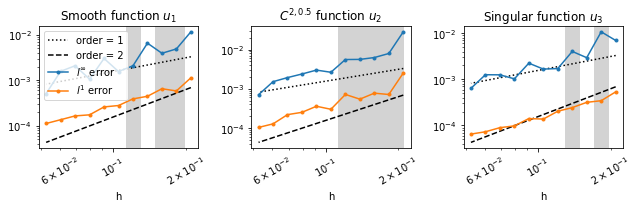

In [13]:
d = 3
mu = 1
nu = 1 / 10
h = 0.21 / 2 ** np.arange(0, 2.2, 0.2)

plt.figure(figsize=(9, 3))

for i, (u_func, title) in enumerate(
    [
        (u1, "Smooth function $u_1$"),
        (u2, "$C^{2, 0.5}$ function $u_2$"),
        (u3, "Singular function $u_3$"),
    ]
):
    err_l1 = np.zeros(h.shape)
    err_linf = np.zeros(h.shape)

    plt.subplot(131 + i)
    plt.title(title)
    plt.xlabel("h")

    for j in range(len(h)):
        x = grid(d, h[j])
        bc = Domain.Dirichlet(domain(d), u_func, x)

        u = u_func(x)
        f = EqNonlinear(u_func, x)

        u_approx, dde = SolveNonlinear(x, f, bc)

        print(h[j], dde)

        if not dde:
            plt.axvspan(
                np.exp((np.log(h[min(len(h) - 1, j + 1)]) + np.log(h[j])) / 2),
                np.exp((np.log(h[j]) + np.log(h[max(0, j - 1)])) / 2),
                color="lightgray",
            )

        err_l1[j] = np.mean(np.abs(np.where(bc.interior, u - u_approx, 0)))
        err_linf[j] = np.max(np.abs(np.where(bc.interior, u - u_approx, 0)))

    plt.loglog(h, h / 64, "k:", label="order = 1")
    plt.loglog(h, h ** 2 / 64, "k--", label="order = 2")
    plt.loglog(h, err_linf, ".-", label="$l^\infty$ error")
    plt.loglog(h, err_l1, ".-", label="$l^1$ error")

    if i == 0:
        plt.legend()
    plt.xticks(rotation=30)
    for text in plt.gca().get_xminorticklabels():
        text.set_rotation(30)

plt.tight_layout()
plt.savefig("nonlinear-convergence-3d.png")
plt.show()